In [253]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler as ss, OneHotEncoder as ohe, MinMaxScaler as mms

from catboost import CatBoostRegressor as cat
from lightgbm import LGBMRegressor as lgbm

plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [5]:
train = pd.read_csv('open/train.csv').drop('ID',axis=1)
test = pd.read_csv('open/test.csv').drop('ID',axis=1)
train.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57920 entries, 0 to 57919
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   생산년도         57920 non-null  int64  
 1   모델출시년도       57920 non-null  int64  
 2   브랜드          57920 non-null  object 
 3   차량모델명        57920 non-null  object 
 4   판매도시         57920 non-null  object 
 5   판매구역         57920 non-null  object 
 6   주행거리         57920 non-null  int64  
 7   배기량          57920 non-null  int64  
 8   압축천연가스(CNG)  57920 non-null  int64  
 9   경유           57920 non-null  int64  
 10  가솔린          57920 non-null  int64  
 11  하이브리드        57920 non-null  int64  
 12  액화석유가스(LPG)  57920 non-null  int64  
 13  가격           57920 non-null  float64
dtypes: float64(1), int64(9), object(4)
memory usage: 6.2+ MB


In [7]:
train.describe()

,생산년도,모델출시년도,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
count,57920.000000,57920.000000,5.792000e+04,57920.000000,57920.000000,57920.000000,57920.000000,57920.000000,57920.000000,57920.000000
mean,2011.355352,2008.033408,1.678691e+05,1788.160135,0.000483,0.425242,0.517956,0.010290,0.046029,52.211752
std,5.174108,5.087963,8.319120e+04,545.413818,0.021982,0.494384,0.499682,0.100918,0.209550,35.399718
min,1978.000000,1983.000000,1.000000e+00,875.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.170000
25%,2008.000000,2004.000000,1.114345e+05,1461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.570000
50%,2011.000000,2008.000000,1.710000e+05,1753.000000,0.000000,0.000000,1.000000,0.000000,0.000000,42.250000
75%,2016.000000,2012.000000,2.200000e+05,1995.000000,0.000000,1.000000,1.000000,0.000000,0.000000,73.970000
max,2022.000000,2021.000000,2.500000e+06,6300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,156.000000


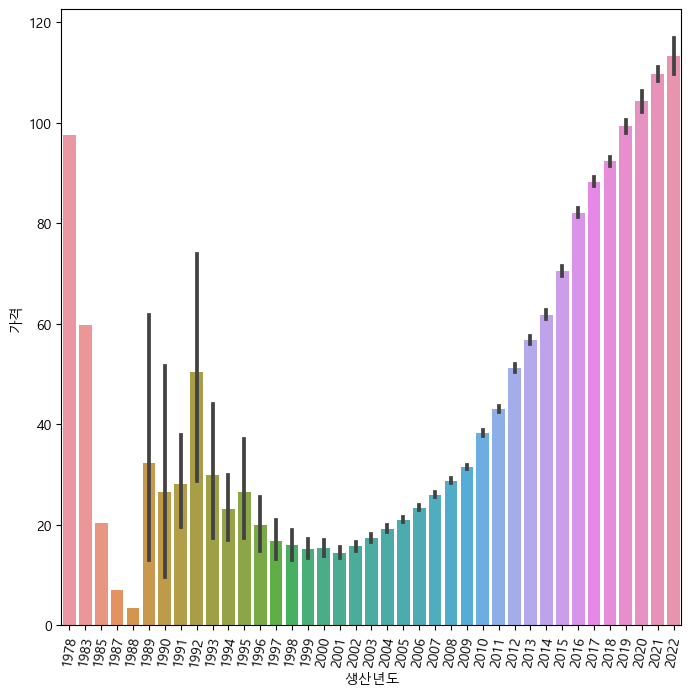

In [8]:
plt.figure(figsize = (8,8))
sns.barplot(x = train['생산년도'], y = train['가격'])
plt.xticks(rotation=80)
plt.show()

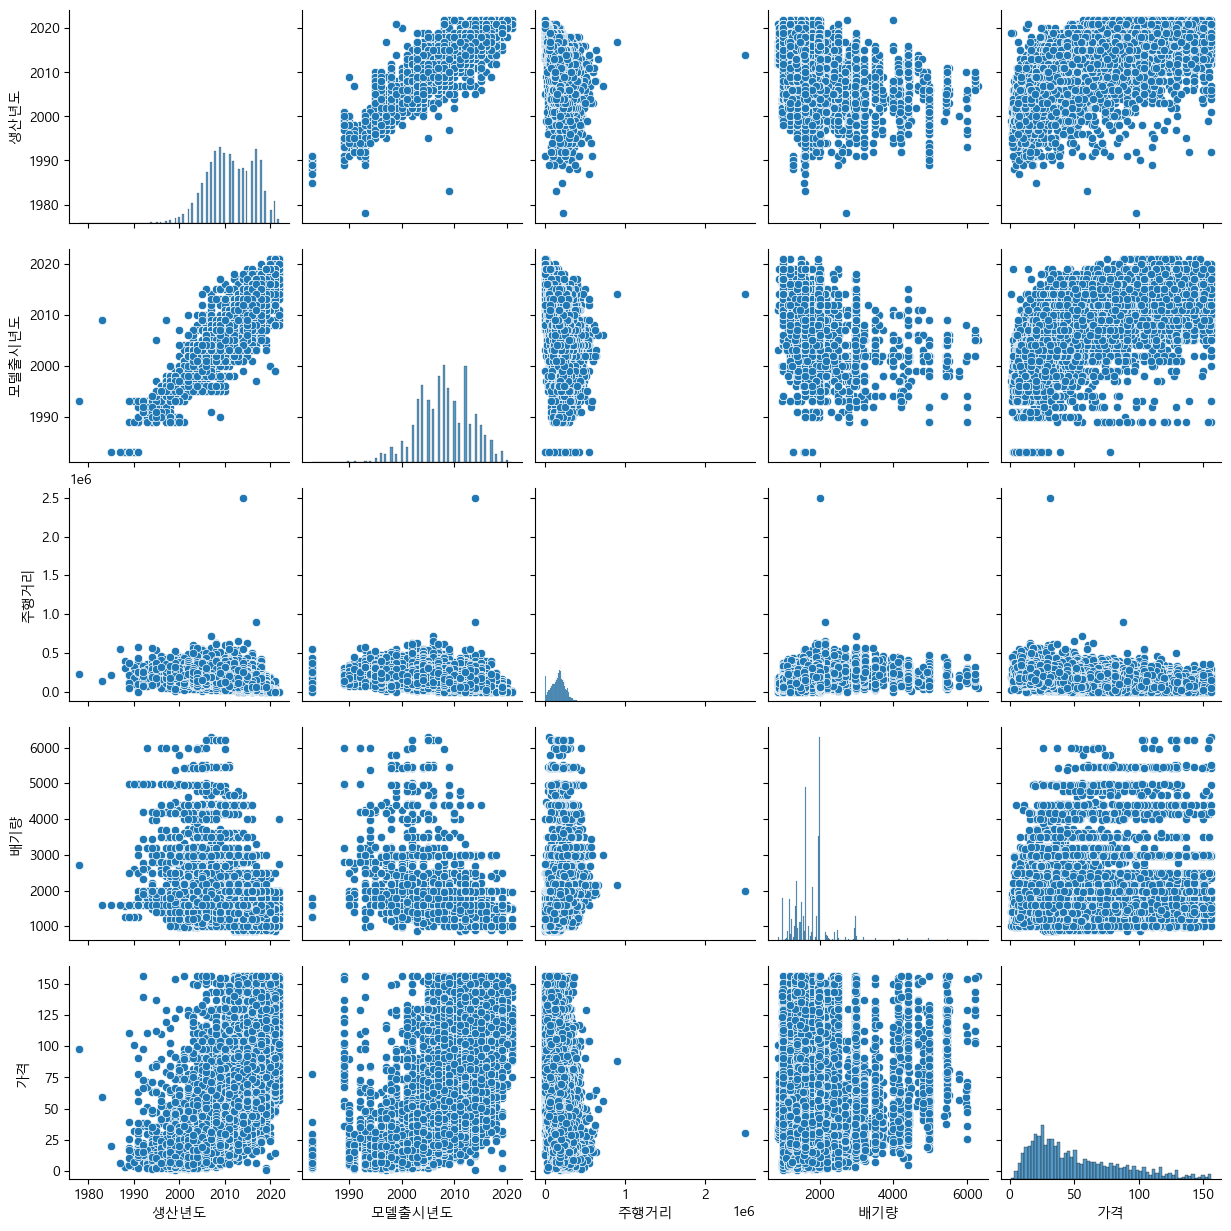

In [28]:
sns.pairplot(train.drop(['브랜드','차량모델명','판매도시','판매구역','압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1))

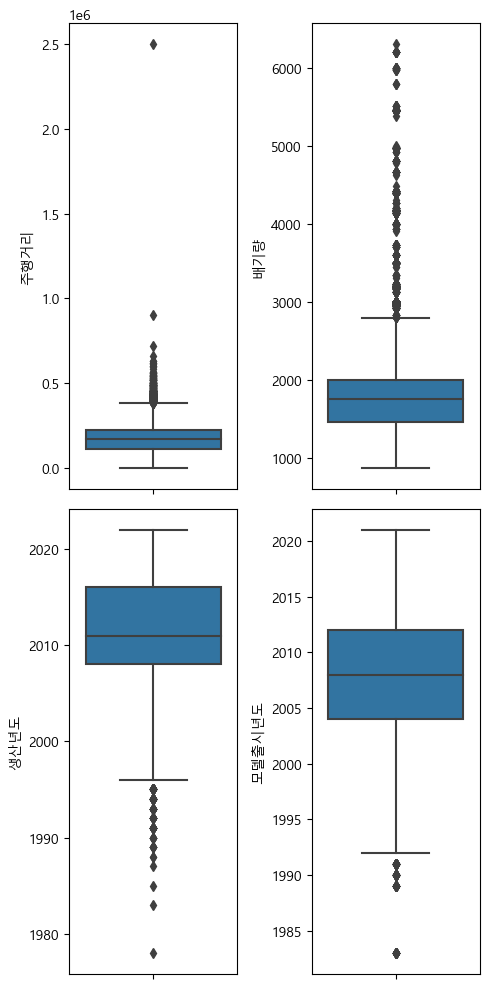

In [10]:
fig, axes = plt.subplots(2,2, figsize = (5,10))

sns.boxplot(y = train['주행거리'], ax = axes[0][0])
sns.boxplot(y = train['배기량'], ax = axes[0][1])

sns.boxplot(y = train['생산년도'], ax = axes[1][0])
sns.boxplot(y = train['모델출시년도'], ax = axes[1][1])

plt.tight_layout()
plt.show()

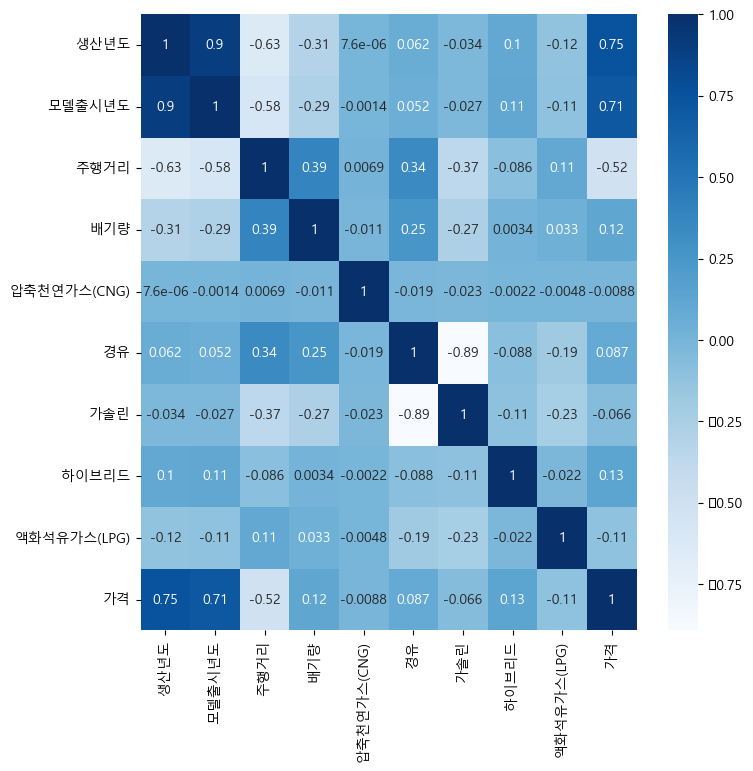

In [11]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [43]:
man = '현석'
print(f'{man} man')

현석 man


In [44]:
# 주행거리, 배기량 이상치 제거
def make_normal(df, col):
    Q3 = np.quantile(df[col],.75)
    Q1 = np.quantile(df[col],.25)
    IQR = Q3 - Q1
    maximum = Q3 + (1.5*IQR)
    minimum = Q1 - (1.5*IQR)

    lst = []
    for val in df[col]:
        if val > maximum:
            val = maximum

        if val < minimum:
            val = minimum

        lst.append(val)

    df[col] = lst
    print(f'{col} change Done.')

make_normal(train,'주행거리')
make_normal(train,'배기량')

주행거리 change Done.
배기량 change Done.


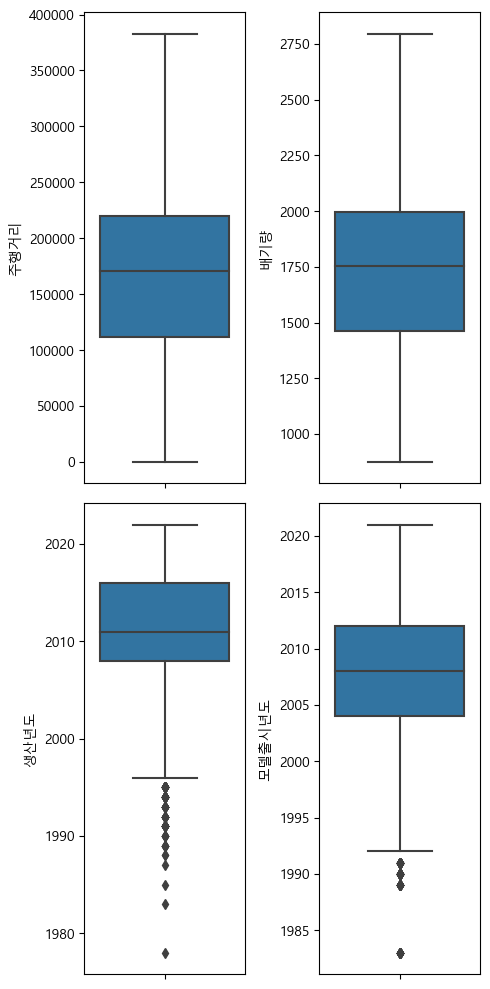

In [45]:
fig, axes = plt.subplots(2,2, figsize = (5,10))

sns.boxplot(y = train['주행거리'], ax = axes[0][0])
sns.boxplot(y = train['배기량'], ax = axes[0][1])

sns.boxplot(y = train['생산년도'], ax = axes[1][0])
sns.boxplot(y = train['모델출시년도'], ax = axes[1][1])

plt.tight_layout()
plt.show()

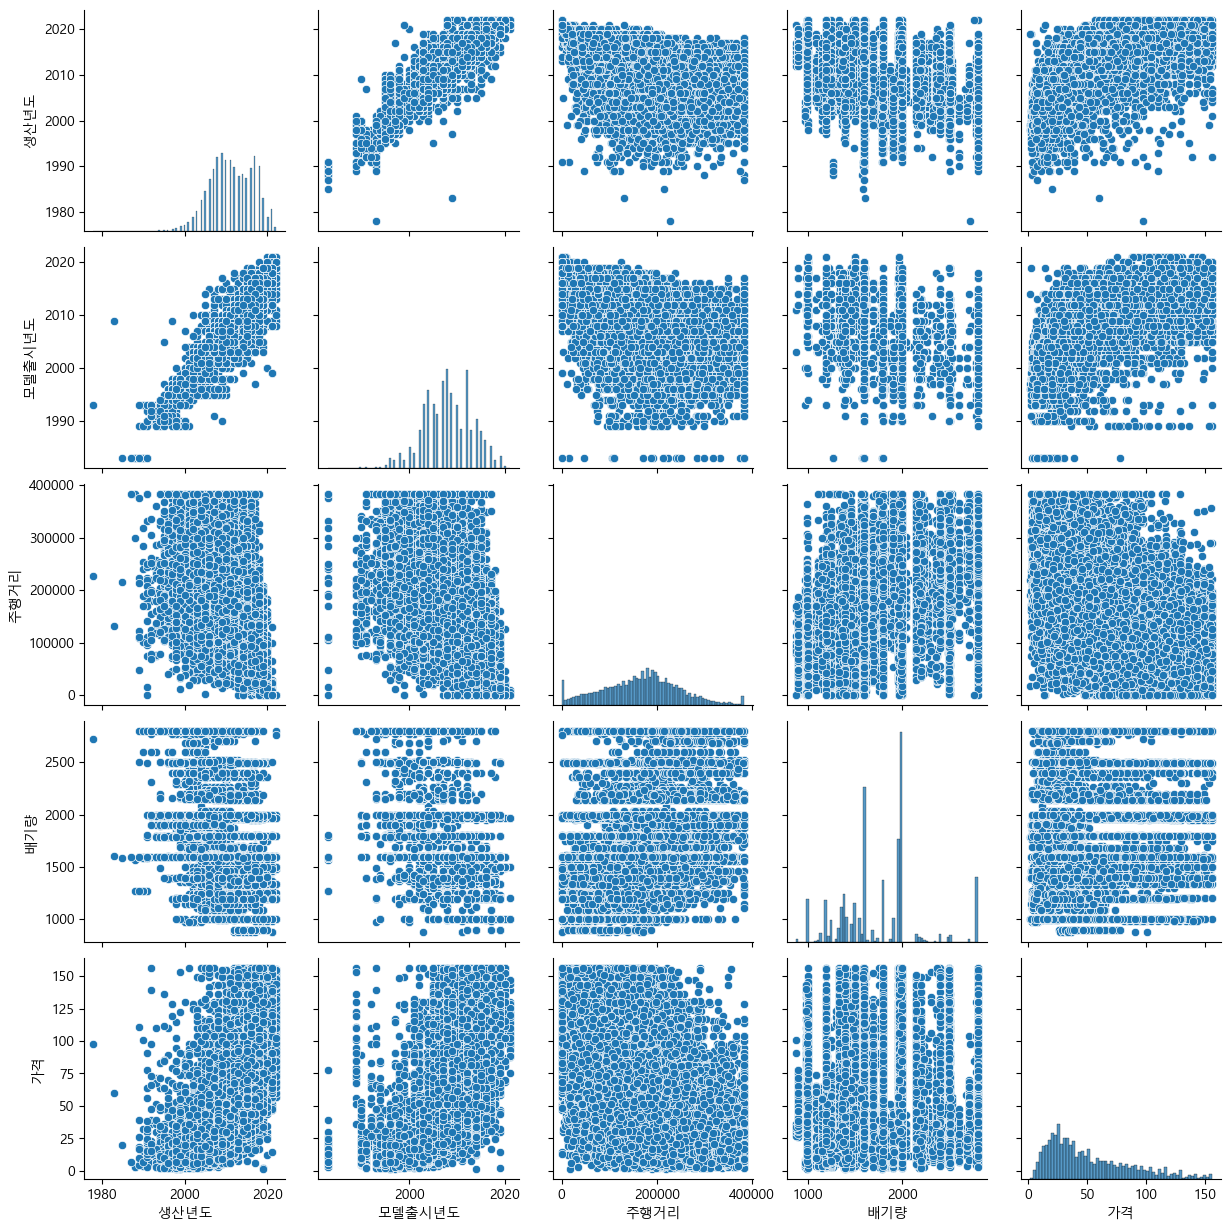

In [46]:
sns.pairplot(train.drop(['브랜드','차량모델명','판매도시','판매구역','압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1))

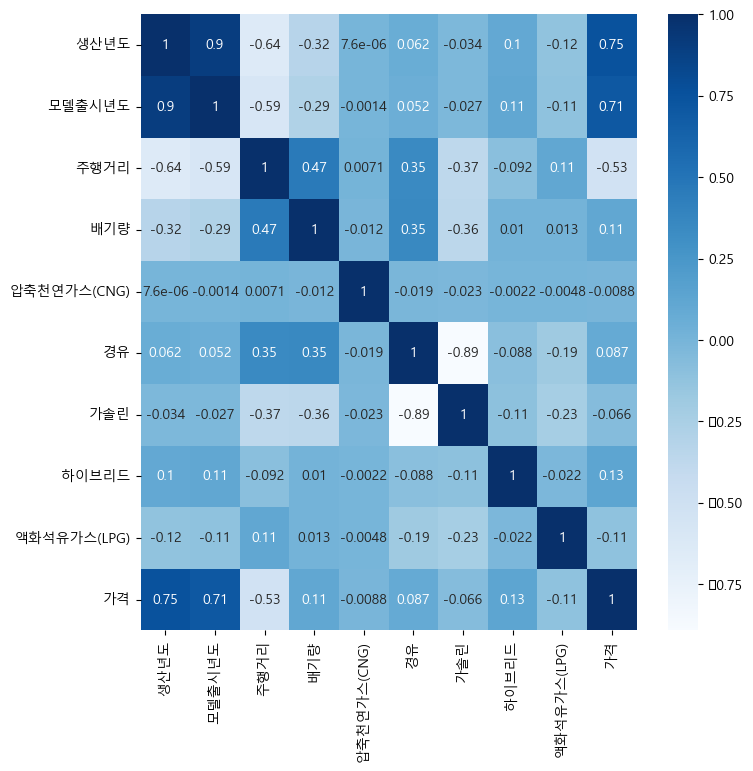

In [47]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [48]:
train.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,51.74
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,41.47
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,17.81
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,18.20
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,17.55


In [58]:
lst = []
for val in train['배기량']:
    if val > 2500:
        lst.append('high')
    elif val < 1000:
        lst.append('low')
    else:
        lst.append('medium')

train['배기량별 구분'] = lst

In [63]:
lst = []
for val in test['배기량']:
    if val > 2500:
        lst.append('high')
    elif val < 1000:
        lst.append('low')
    else:
        lst.append('medium')

test['배기량별 구분'] = lst

In [72]:
lst = []
for val in train['주행거리']:
    if val >= 100000:
        lst.append('high')
    elif val >= 50000:
        lst.append('medium')
    else:
        lst.append('low')

train['주행거리별 구분'] = lst

lst = []
for val in test['주행거리']:
    if val >= 100000:
        lst.append('high')
    elif val >= 50000:
        lst.append('medium')
    else:
        lst.append('low')

test['주행거리별 구분'] = lst

In [78]:
DICT_cc = {}
DICT_km = {}

DICT_cc['low'] = 0
DICT_cc['medium'] = 1
DICT_cc['high'] = 2

DICT_km['low'] = 2
DICT_km['medium'] = 1
DICT_km['high'] = 0

In [82]:
train['주행거리별 구분'] = train['주행거리별 구분'].map(DICT_km)
train['배기량별 구분'] = train['배기량별 구분'].map(DICT_cc)

In [85]:
test['주행거리별 구분'] = test['주행거리별 구분'].map(DICT_km)
test['배기량별 구분'] = test['배기량별 구분'].map(DICT_cc)

In [83]:
train.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,배기량별 구분,주행거리별 구분
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,51.74,0,1
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,41.47,1,0
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,17.81,1,0
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,18.20,1,0
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,17.55,1,0


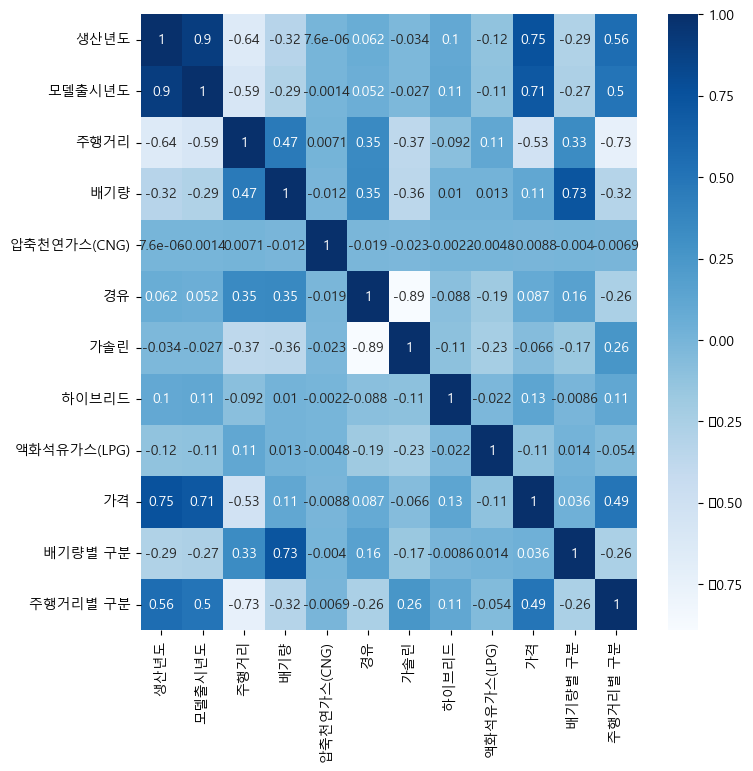

In [84]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [108]:
encoder = ohe(sparse=False).fit(X=train['배기량별 구분'].unique().reshape(-1,1))
encoder.categories_

[array([0, 1, 2], dtype=int64)]

In [110]:
train = pd.concat([train,pd.DataFrame(encoder.transform(train[['배기량별 구분']]),columns=['저배기량','중배기량','고배기량'])],axis=1).drop('배기량별 구분',axis=1)
test = pd.concat([test,pd.DataFrame(encoder.transform(test[['배기량별 구분']]),columns=['저배기량','중배기량','고배기량'])], axis=1).drop('배기량별 구분',axis=1)

In [111]:
train.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,주행거리별 구분,저배기량,중배기량,고배기량
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,51.74,1,1.0,0.0,0.0
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,41.47,0,0.0,1.0,0.0
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,17.81,0,0.0,1.0,0.0
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,18.20,0,0.0,1.0,0.0
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,17.55,0,0.0,1.0,0.0


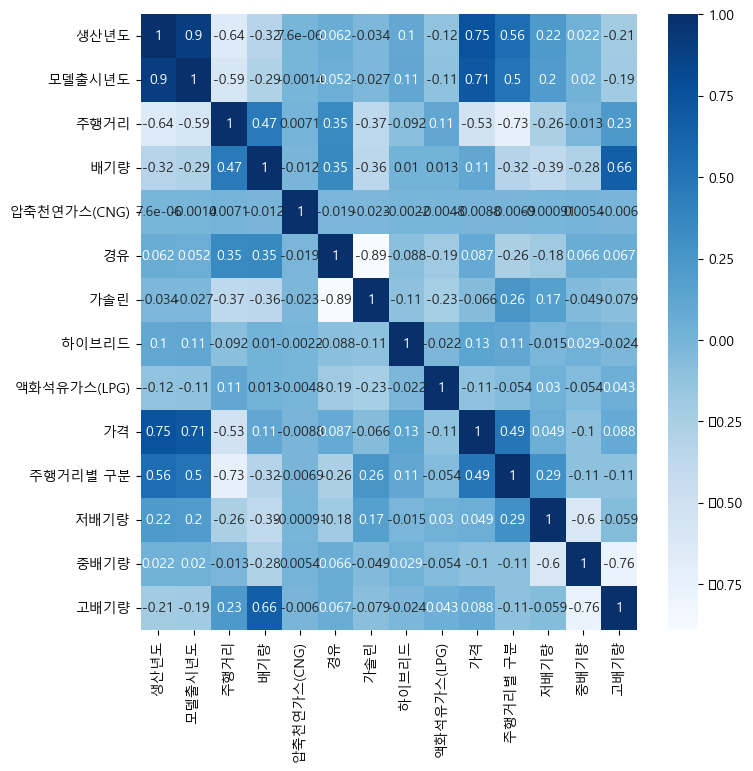

In [112]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [147]:
train['생산경과시간'] = 2023 - train['생산년도']
train['출시경과시간'] = 2023 - train['모델출시년도']

test['생산경과시간'] = 2023 - test['생산년도']
test['출시경과시간'] = 2023 - test['모델출시년도']

In [150]:
lst = []
for val in train['생산경과시간']:
    if val > 5:
        lst.append('old')
    elif val > 10:
        lst.append('very old')
    else:
        lst.append('recent')
train['생산경과시간'] = lst

lst = []
for val in test['생산경과시간']:
    if val > 5:
        lst.append('old')
    elif val > 10:
        lst.append('very old')
    else:
        lst.append('recent')
test['생산경과시간'] = lst

lst = []
for val in train['출시경과시간']:
    if val > 5:
        lst.append('old')
    elif val > 10:
        lst.append('very old')
    else:
        lst.append('recent')
train['출시경과시간'] = lst

lst = []
for val in test['출시경과시간']:
    if val > 5:
        lst.append('old')
    elif val > 10:
        lst.append('very old')
    else:
        lst.append('recent')
test['출시경과시간'] = lst

In [152]:
DICT_time = {}

DICT_time['recent'] = 2
DICT_time['old'] = 1
DICT_time['very old'] = 0

print(DICT_time)

{'recent': 2, 'old': 1, 'very old': 0}


In [155]:
train['출시경과시간'] = train['출시경과시간'].map(DICT_time)
train['생산경과시간'] = train['생산경과시간'].map(DICT_time)

test['출시경과시간'] = test['출시경과시간'].map(DICT_time)
test['생산경과시간'] = test['생산경과시간'].map(DICT_time)

In [165]:
brand_idx = train[['브랜드','가격']].groupby(['브랜드']).mean().sort_values('가격').index
dict_brand = {}
for i in range(len(brand_idx)):
    key = brand_idx[i]
    value = i
    dict_brand[key] = value

train['브랜드'] = train['브랜드'].map(dict_brand)
test['브랜드'] = test['브랜드'].map(dict_brand)

In [176]:
model_idx = train[['차량모델명','가격']].groupby(['차량모델명']).mean().sort_values('가격').index
dict_model = {}
for i in range(len(model_idx)):
    key = model_idx[i]
    value = i
    dict_model[key] = value

train['차량모델명'] = train['차량모델명'].map(dict_model)
test['차량모델명'] = test['차량모델명'].map(dict_model)

In [ ]:
brand_idx = train[['브랜드','가격']].groupby(['브랜드']).mean().sort_values('가격').index
dict_brand = {}
for i in range(len(brand_idx)):
    key = brand_idx[i]
    value = i
    dict_brand[key] = value

train['브랜드'] = train['브랜드'].map(dict_brand)
test['브랜드'] = test['브랜드'].map(dict_brand)

In [205]:
city_idx = train[['판매도시','가격']].groupby(['판매도시']).mean().sort_values('가격').index
dict_city = {}
for i in range(len(city_idx)):
    key = city_idx[i]
    value = i
    dict_city[key] = value

train['판매도시'] = train['판매도시'].map(dict_city)
test['판매도시'] = test['판매도시'].map(dict_city)

sector_idx = train[['판매구역','가격']].groupby(['판매구역']).mean().sort_values('가격').index
dict_sector = {}
for i in range(len(sector_idx)):
    key = sector_idx[i]
    value = i
    dict_sector[key] = value

train['판매구역'] = train['판매구역'].map(dict_sector)
test['판매구역'] = test['판매구역'].map(dict_sector)

In [209]:
train_x = train.drop('가격',axis=1)
train_y = train['가격']
test_x = test

In [212]:
scaler = ss()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [219]:
train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x.columns)
test_x_scaled = pd.DataFrame(test_x_scaled, columns=test_x.columns)

In [225]:
model = cat(random_state=42, loss_function='MAE', eval_metric='MAE')
model2 = lgbm(random_state=42, loss_function='MAE', use_best_model=True, eval_metric='MAE')

In [226]:
param_cat={
    'iterations':[500,1000]
}
param_lgbm={
    'n_estimators':[100,300]
}
grid = GridSearchCV(model, param_grid=param_cat, scoring='neg_mean_absolute_error', cv=4, refit=True, verbose=2)
grid2 = GridSearchCV(model2, param_grid=param_lgbm, scoring='neg_mean_absolute_error', cv=4, refit=True, verbose=2)

grid.fit(train_x_scaled, train_y)
grid2.fit(train_x_scaled, train_y)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
0:	learn: 27.2140367	total: 153ms	remaining: 1m 16s
1:	learn: 26.5577343	total: 162ms	remaining: 40.3s
2:	learn: 25.9142082	total: 169ms	remaining: 28s
3:	learn: 25.2998502	total: 176ms	remaining: 21.8s
4:	learn: 24.7170178	total: 180ms	remaining: 17.9s
5:	learn: 24.1408773	total: 185ms	remaining: 15.2s
6:	learn: 23.5796404	total: 189ms	remaining: 13.3s
7:	learn: 23.0475385	total: 194ms	remaining: 11.9s
8:	learn: 22.5359656	total: 198ms	remaining: 10.8s
9:	learn: 22.0308204	total: 201ms	remaining: 9.86s
10:	learn: 21.5742729	total: 205ms	remaining: 9.13s
11:	learn: 21.1104655	total: 209ms	remaining: 8.51s
12:	learn: 20.6789215	total: 213ms	remaining: 7.97s
13:	learn: 20.2527339	total: 216ms	remaining: 7.5s
14:	learn: 19.8557785	total: 220ms	remaining: 7.13s
15:	learn: 19.4538796	total: 224ms	remaining: 6.78s
16:	learn: 19.0886396	total: 228ms	remaining: 6.46s
17:	learn: 18.7164251	total: 231ms	remaining: 6.19s
18:	learn: 18.363

GridSearchCV(cv=4,
             estimator=LGBMRegressor(eval_metric='MAE', loss_function='MAE',
                                     random_state=42, use_best_model=True),
             param_grid={'n_estimators': [100, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [229]:
print(grid.best_params_)
print(grid2.best_params_)
print(grid.best_score_)
print(grid2.best_score_)

{'iterations': 1000}
{'n_estimators': 300}
-6.35070404427622
-6.025856041062502


In [231]:
x_train, x_val, y_train, y_val = train_test_split(train_x_scaled, train_y, random_state=42)

In [232]:
model_new = lgbm(random_state=42, n_estimators=300)
model_new.fit(x_train, y_train)

LGBMRegressor(n_estimators=300, random_state=42)

In [233]:
mae(y_val, model_new.predict(x_val))

5.975729545264294

In [242]:
model_new2 = lgbm(random_state=42, n_estimators=300)
model_new2.fit(train_x_scaled,train_y)

LGBMRegressor(n_estimators=300, random_state=42)

In [243]:
mae(y_val, model_new2.predict(x_val))

5.452544544684806

In [244]:
mae(y_val, np.round(model_new2.predict(x_val)))

5.458238259668509

In [241]:
mae(y_val, np.round(model_new.predict(x_val)))

5.984413674033149

In [246]:
preds = model_new2.predict(test_x_scaled)

In [247]:
submission = pd.read_csv('open/sample_submission.csv')
submission['가격'] = preds
submission.to_csv('./lgbm.csv', index = False)

In [252]:
scaler2 = mms()
scaler2.fit(train_x)

MinMaxScaler()

<Figure size 1500x1500 with 0 Axes>

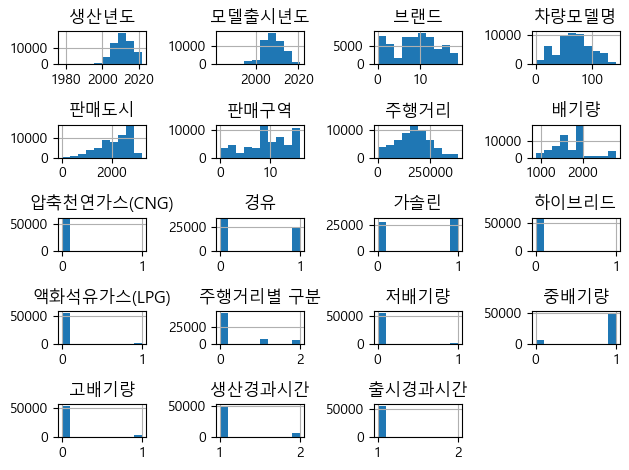

In [259]:
plt.figure(figsize=(15,15))
train_x.hist()
plt.tight_layout()

In [279]:
new_train = train_x.copy()
new_test = test_x.copy()

In [287]:
scaler2 = mms()
scaler2.fit(new_train)

MinMaxScaler()

In [290]:
new_train = pd.DataFrame(scaler2.transform(new_train),columns=new_train.columns)
new_test = pd.DataFrame(scaler2.transform(new_test),columns=new_test.columns)

In [291]:
new_train.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),주행거리별 구분,저배기량,중배기량,고배기량,생산경과시간,출시경과시간
0,0.870256,0.768793,0.894737,0.309859,0.843624,0.750,0.222621,0.064550,0.0,0.0,1.0,0.0,0.0,0.5,1.0,0.0,0.0,1.0,0.0
1,0.638787,0.533538,0.789474,0.605634,0.525597,0.000,0.352618,0.376366,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.440324,0.426447,0.526316,0.197183,0.574620,0.500,0.666642,0.479438,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.535733,0.400702,0.684211,0.873239,0.546075,0.500,0.621655,0.681416,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.560758,0.561370,0.210526,0.077465,0.752405,0.625,0.655611,0.538782,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [292]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(new_train, train_y, random_state=42)

In [293]:
model_new = lgbm(random_state=42, n_estimators=300)
model_new.fit(x_train2, y_train2)
mae(y_val2, model_new.predict(x_val2))

5.975895342286737

In [326]:
new_train2 = train_x.copy()
new_test2 = test_x.copy()

In [327]:
scaler2 = mms()
scaler2.fit(new_train2)
new_train2 = pd.DataFrame(scaler2.transform(new_train2),columns=new_train.columns)
new_test2 = pd.DataFrame(scaler2.transform(new_test2),columns=new_test.columns)

In [328]:
from tqdm import tqdm

for col in tqdm(new_train2.columns[:8]):
    try:
        new_train2[col] = boxcox(new_train2[col])[0]
    except:
        new_train2[col] = new_train2[col]+1
        new_train2[col] = boxcox(new_train2[col])[0]

for col in tqdm(new_test2.columns[:8]):
    try:
        new_test2[col] = boxcox(new_test2[col])[0]
    except:
        new_test2[col] = new_test2[col]+1
        new_test2[col] = boxcox(new_test2[col])[0]

100%|██████████| 8/8 [00:00<00:00, 122.40it/s]


<Figure size 1500x1500 with 0 Axes>

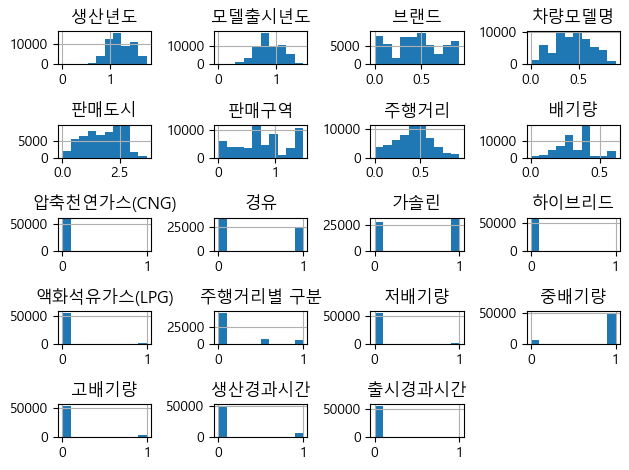

In [331]:
plt.figure(figsize=(15,15))
new_train2.hist()
plt.tight_layout()

In [330]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(new_train2, train_y, random_state=42)

In [357]:
model_new2 = lgbm(random_state=42, n_estimators=300)
model_new2.fit(x_train3,y_train3)

LGBMRegressor(n_estimators=300, random_state=42)

In [344]:
mae(y_val3, model_new2.predict(x_val3))

5.975848109215949

In [351]:
mae(y_val3, np.round(model_new2.predict(x_val3),4))

5.975847776243094

In [352]:
model_new2 = lgbm(random_state=42, n_estimators=300)
model_new2.fit(new_train2,train_y)

LGBMRegressor(n_estimators=300, random_state=42)

In [356]:
mae(y_val3, model_new2.predict(x_val3))
mae(y_val3, np.round(model_new2.predict(x_val3),4))

5.454812610497237

In [358]:
preds = model_new2.predict(new_test2)

In [359]:
submission = pd.read_csv('open/sample_submission.csv')
submission['가격'] = preds
submission.to_csv('./lgbm_boxcox_val.csv', index = False)

In [360]:
preds

array([17.6693862 , 15.06908807, 15.0513167 , ..., 26.46821492,
       12.83680184, 14.52497801])